<a href="https://colab.research.google.com/github/gongx030/etv2_pioneer/blob/master/chromVAR_Brg1_KD_ATAC_D7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# chromVAR analysis of Brg1 KD ATAC-seq data at D7

by Wuming Gong



In [113]:
start_time0 <- Sys.time()

### Install external packages

In [114]:
system('apt-get -q install libgsl-dev', intern = TRUE)

[1] "Reading package lists..."                                       
[2] "Building dependency tree..."                                    
[3] "Reading state information..."                                   
[4] "libgsl-dev is already the newest version (2.4+dfsg-6)."         
[5] "0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded."

In [115]:
system('apt-get install libcairo2-dev', intern = TRUE) # for Cairo package that is required by ComplexHeatmap package

[1] "Reading package lists..."                                         
[2] "Building dependency tree..."                                      
[3] "Reading state information..."                                     
[4] "libcairo2-dev is already the newest version (1.15.10-2ubuntu0.1)."
[5] "0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded."

### Install R packages

In [116]:
install.packages('BiocManager')

Installing package into '/usr/local/lib/R/site-library'
(as 'lib' is unspecified)



In [117]:
required_packages <- c(
  'devtools', 'circlize', 'dplyr', 'gplots',
  'SummarizedExperiment', 'BSgenome.Mmusculus.UCSC.mm10', 'BiocParallel', 'ComplexHeatmap', 
  'rtracklayer', 'EnrichedHeatmap', 'ChIPpeakAnno', 'ChIPseeker', 'TxDb.Mmusculus.UCSC.mm10.knownGene', 
  'org.Mm.eg.db', 'clusterProfiler', 'ReactomePA',
  'gsl', 'DirichletMultinomial', 'chromVAR', 'motifmatchr', 'PWMEnrich'
)

In [118]:
missing_packages <- required_packages[!required_packages %in% rownames(installed.packages())]
if (length(missing_packages) > 0){
    BiocManager::install(missing_packages)
}

### Install `chromVAR` and `chromVARmotifs`

In [119]:
devtools::install_github("GreenleafLab/chromVARmotifs")

Skipping install of 'chromVARmotifs' from a github remote, the SHA1 (38bed559) has not changed since last install.
  Use `force = TRUE` to force installation



### Load R packages

In [120]:
library(chromVARmotifs)
library(chromVAR)
library(BSgenome.Mmusculus.UCSC.mm10)
library(motifmatchr)
library(BiocParallel)
register(MulticoreParam(2))
library(SummarizedExperiment)
library(gplots)
library(circlize)
library(dplyr)
library(ComplexHeatmap)
library(EnrichedHeatmap)
library(rtracklayer)
library(parallel)
library(ChIPpeakAnno)
library(ChIPseeker)
library(TxDb.Mmusculus.UCSC.mm10.knownGene)
library(org.Mm.eg.db)
library(clusterProfiler)
library(ReactomePA)

## Load the motif PWMs

In [121]:
data("homer_pwms") 

In [122]:
Etv2_canonical <- homer_pwms[['Etv2(ETS)/ES-ER71-ChIP-Seq(GSE59402)/Homer(0.967)']]
Etv2_canonical
Etv2_partial <- reverseComplement(Etv2_canonical)
Etv2_partial@profileMatrix <- Etv2_partial@profileMatrix[, 1:8]
Etv2_partial@ID <- 'Etv2(ETS)/Partial'
Etv2_partial@name <- 'Etv2(ETS)/Partial'
Etv2_partial

An object of class PWMatrix
ID: Etv2(ETS)/ES-ER71-ChIP-Seq(GSE59402)/Homer(0.967)
Name: Etv2(ETS)
Matrix Class: Unknown
strand: +
Pseudocounts: 
Tags: 
$evidence
[1] "ES-ER71-ChIP-Seq(GSE59402)"

$source
[1] "Homer(0.967)"

Background: 
   A    C    G    T 
0.25 0.25 0.25 0.25 
Matrix: 
         [,1]       [,2]        [,3]       [,4]        [,5]      [,6]      [,7]
A -0.16016875 -0.3856625  0.60758929 -2.3859667  0.08801088 -5.521461 -5.521461
C  0.18564935  0.1988509 -0.60880603  0.6418539 -5.52146092 -5.521461  1.383290
G  0.02371653 -0.0618754  0.06203539 -0.9571127 -2.74887220 -5.521461 -5.521461
T -0.08338161  0.1484200 -0.58698698  0.4848922  1.04380405  1.383290 -5.521461
       [,8]       [,9]       [,10]      [,11]       [,12]
A -5.521461 -2.4304185 -1.53247687 -0.1544844 -0.46621461
C  1.383290 -2.4304185 -0.03666398  0.1071607  0.09066769
G -5.521461  0.4134333  0.69912925 -0.3787969  0.09431068
T -5.521461  0.8381130 -0.21319322  0.2966507  0.16451494

An object of class PWMatrix
ID: Etv2(ETS)/Partial
Name: Etv2(ETS)/Partial
Matrix Class: Unknown
strand: -
Pseudocounts: 
Tags: 
$evidence
[1] "ES-ER71-ChIP-Seq(GSE59402)"

$source
[1] "Homer(0.967)"

Background: 
   A    C    G    T 
0.25 0.25 0.25 0.25 
Matrix: 
         [,1]       [,2]        [,3]       [,4]      [,5]      [,6]      [,7]
A  0.16451494  0.2966507 -0.21319322  0.8381130 -5.521461 -5.521461  1.383290
C  0.09431068 -0.3787969  0.69912925  0.4134333 -5.521461 -5.521461 -5.521461
G  0.09066769  0.1071607 -0.03666398 -2.4304185  1.383290  1.383290 -5.521461
T -0.46621461 -0.1544844 -1.53247687 -2.4304185 -5.521461 -5.521461 -5.521461
         [,8]
A  1.04380405
C -2.74887220
G -5.52146092
T  0.08801088

In [123]:
Etv2_partial <- as(list(Etv2_partial), 'SimpleList')
names(Etv2_partial) <- 'Etv2_partial'

In [124]:
homer_pwms <- c(Etv2_partial, homer_pwms)

## Read and process the ATAC-seq read counts data 
Read data for each sample and count the motifs at each interval

In [125]:
se <- readRDS(gzcon(url('https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228a/all_ATAC.rds')))
se

class: RangedSummarizedExperiment 
dim: 152282 30 
metadata(0):
assays(1): counts
rownames(152282): chr1 chr1 ... chrY chrY
rowData names(3): score source group
colnames(30): EB_Dox_D25_rep1 EB_Dox_D25_rep2 ...
  MEF_Brg1_KD_NoDox_D7_rep1 MEF_Brg1_KD_NoDox_D7_rep2
colData names(3): bw_file name group

In [126]:
# remove intervals that have reads in at zero or one condition
se <- se[rowSums(assays(se)$counts > 0) >= 2] 
se <- addGCBias(se, genome = BSgenome.Mmusculus.UCSC.mm10)
colData(se)$is_MEF <- grepl('^MEF_', colData(se)$group)
colData(se)$is_EB <- grepl('^EB_', colData(se)$group)
colData(se)$is_flk1pos <- grepl('Flk1pos', colData(se)$group)
colData(se)$is_dox <- grepl('_Dox_', colData(se)$group)
colData(se)$is_Brg1_KD <- grepl('_Brg1_', colData(se)$group)
time <- gsub('_Flk1pos', '', gsub('.+_(D.+)$', '\\1', colData(se)$group))
time[time == 'MEF_NoDox'] <- 'D0'
colData(se)$time <- time

In [127]:
MEF_cols <- colorpanel(4, low = 'black', high = 'green') # time
EB_col <- 'red'
group2col <- c(
  'MEF_NoDox' = MEF_cols[1],
  'MEF_Dox_D1' = MEF_cols[2],
  'MEF_Dox_D2' = MEF_cols[3],
  'MEF_Dox_D7' = MEF_cols[4],
  'MEF_Dox_D7_Flk1pos' = MEF_cols[4],

  'EB_NoDox_D25' = EB_col,
  'EB_Dox_D25' = EB_col,
  'EB_Dox_D25_Flk1pos' = EB_col,
  
  'MEF_Brg1_KD_D0' = MEF_cols[1],
  'MEF_Brg1_KD_Dox_D1' = MEF_cols[2],
  'MEF_Brg1_KD_Dox_D2' = MEF_cols[3],
  'MEF_Brg1_KD_Dox_D7' = MEF_cols[4],
  
  'MEF_Brg1_KD_NoDox_D1' = MEF_cols[2],
  'MEF_Brg1_KD_NoDox_D2' = MEF_cols[3],
  'MEF_Brg1_KD_NoDox_D7' = MEF_cols[4]
)
pch <- rep(21, ncol(se))
pch[colData(se)$is_Brg1_KD] <- 24
colData(se)$pch <- pch
colData(se)$bg <- group2col[as.character(colData(se)$group)]
colData(se)$col <- group2col[as.character(colData(se)$group)]
colData(se)                             

DataFrame with 30 rows and 12 columns
                                                                                                                                                        bw_file
                                                                                                                                                       <factor>
EB_Dox_D25_rep1                             https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/EB_Dox_D25_rep1_treat_pileup.bw        
EB_Dox_D25_rep2                             https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/EB_Dox_D25_rep2_treat_pileup.bw        
EB_NoDox_D25_rep1                           https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/EB_NoDox_D25_rep1_treat_pileup.bw      
EB_NoDox_D25_rep2                           https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2ATAC_version=20190228b/EB_NoDox_D25_rep2_treat_pileup.bw      
EB

## chromVAR analysis

In [128]:
set.seed(1)
include <- colData(se)$is_MEF & colData(se)$time == 'D7'
se_D7 <- se[, include]
se_D7 <- se_D7[rowSums(assays(se_D7)$counts > 0) >= 2]
motif_ix <- matchMotifs(homer_pwms, se_D7, genome = 'mm10')
dev_D7 <- computeDeviations(object = se_D7, annotations = motif_ix)
v_D7 <- computeVariability(dev_D7)

PCA of the motif deiviations

# of significant motifs: 230(333)


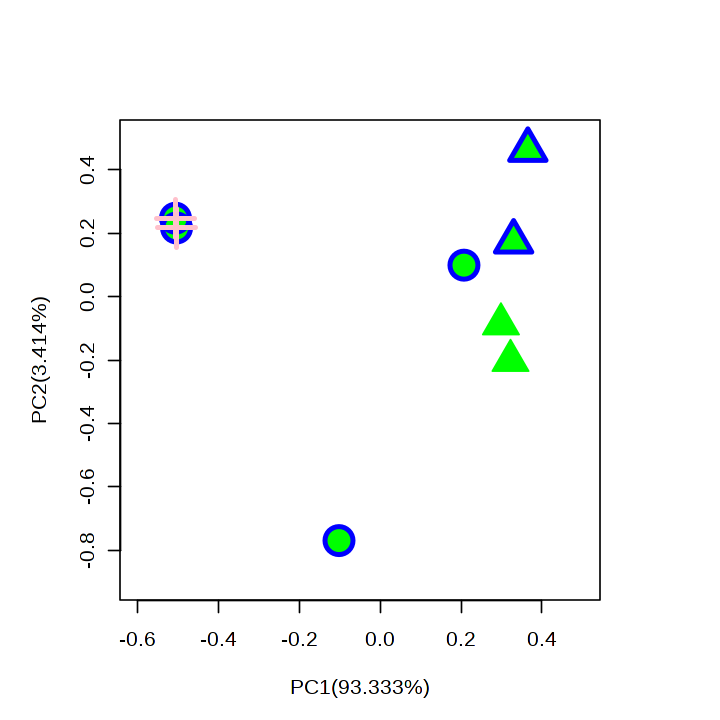

In [129]:
m <- v_D7$p_value_adj < 1e-10
cat(sprintf('# of significant motifs: %d(%d)\n', sum(m), length(m)))
s <- prcomp(assays(dev_D7)$z[m, ])
eigs <- s$sdev^2
z <- s$rotation

pc_x <- 1; pc_y <- 2
cex <- 3

par(mar = c(5, 5, 5, 5))
options(repr.plot.width=6, repr.plot.height=6)
plot(
  z[, pc_x], z[, pc_y], 
  pch = colData(se_D7)$pch, 
  bg = colData(se_D7)$bg, 
  col = colData(se_D7)$col, 
  cex = cex, 
  xlab = sprintf('PC%d(%.3f%%)', pc_x, eigs[pc_x] / sum(eigs) * 100), 
  ylab = sprintf('PC%d(%.3f%%)', pc_y, eigs[pc_y] / sum(eigs) * 100),
  xlim = c(-0.6, 0.5),
  ylim = c(-0.9, 0.5)
)
points(
  z[colData(se_D7)$is_dox, pc_x], z[colData(se_D7)$is_dox, pc_y], 
  pch = colData(se_D7)$pch[colData(se_D7)$is_dox], 
  col = 'blue', 
  cex = cex, 
  lwd = 3
)
points(
  z[colData(se_D7)$is_flk1pos, pc_x], z[colData(se_D7)$is_flk1pos, pc_y], 
  pch = 3, 
  col = 'pink', 
  cex = cex, 
  lwd = 3
)

In [130]:
m <- v_D7$p_value_adj < 1e-200
cat(sprintf('# of significant motifs: %d(%d)\n', sum(m), length(m)))
Y <- assays(dev_D7)$z
rownames(Y) <- rowData(dev_D7)$name
Y <- Y[m, ]
col_fun <- colorRamp2(quantile(Y, c(0.1, 0.5, 0.9)), c("blue", "black", "red"))

# of significant motifs: 47(333)


In [131]:
highlights <- c(
  'Etv2(ETS)/Partial',
  'AP-1(bZIP)',
  'Atf3(bZIP)',
  'Bach1(bZIP)',
#  'Bach2(bZIP)',
  'BATF(bZIP)',
#  'EHF(ETS)',
#  'ELF5(ETS)',
  'Elk1(ETS)',
#  'Elk4(ETS)',
  'ERG(ETS)',
  'ETS1(ETS)',
#  'Ets1-distal(ETS)',
#  'ETS:E-box(ETS,bHLH)',
#  'ETS(ETS)',
  'ETS:RUNX(ETS,Runt)',
  'ETV1(ETS)',
  'Etv2(ETS)',
#  'EWS:ERG-fusion(ETS)',
#  'EWS:FLI1-fusion(ETS)',
  'Fli1(ETS)',
#  'Fosl2(bZIP)',
  'Foxo1(Forkhead)',
  'Fra1(bZIP)',
  'Fra2(bZIP)',
  'GABPA(ETS)',
  'Jun-AP1(bZIP)',
#  'KLF14(Zf)',
  'KLF3(Zf)',
#  'Klf4(Zf)',
#  'KLF5(Zf)',
#  'Klf9(Zf)',
  'Maz(Zf)',
  'Meis1(Homeobox)',
  'NF-E2(bZIP)',
  'NFY(CCAAT)',
  'Nrf2(bZIP)',
  'PBX1(Homeobox)',
  'PU.1(ETS)',
  'RUNX(Runt)',
  'Sp1(Zf)',
  'SPDEF(ETS)',
  'SpiB(ETS)',
#  'TEAD2(TEA)',
  'TEAD(TEA)',
  'VDR(NR),DR3',
  'YY1(Zf)'
)

In [132]:
column_annotation <- HeatmapAnnotation(
  flk1pos = colData(se_D7)$is_flk1pos,
  dox = colData(se_D7)$is_dox,
#  time = colData(se_D7)$time,
  Brg1_KD = colData(se_D7)$is_Brg1_KD,
  col = list(
    dox = c('TRUE' = 'blue', 'FALSE' = 'grey'), 
    flk1pos = c('TRUE' = 'pink', 'FALSE' = 'gray'),
    Brg1_KD  = c('TRUE' = 'yellow', 'FALSE' = 'gray'),
    time = c('D0' = MEF_cols[1], 'D1' = MEF_cols[2],'D2' = MEF_cols[3],'D7' = MEF_cols[4])
  ),
  show_legend = TRUE,
  annotation_name_side = "left"
)

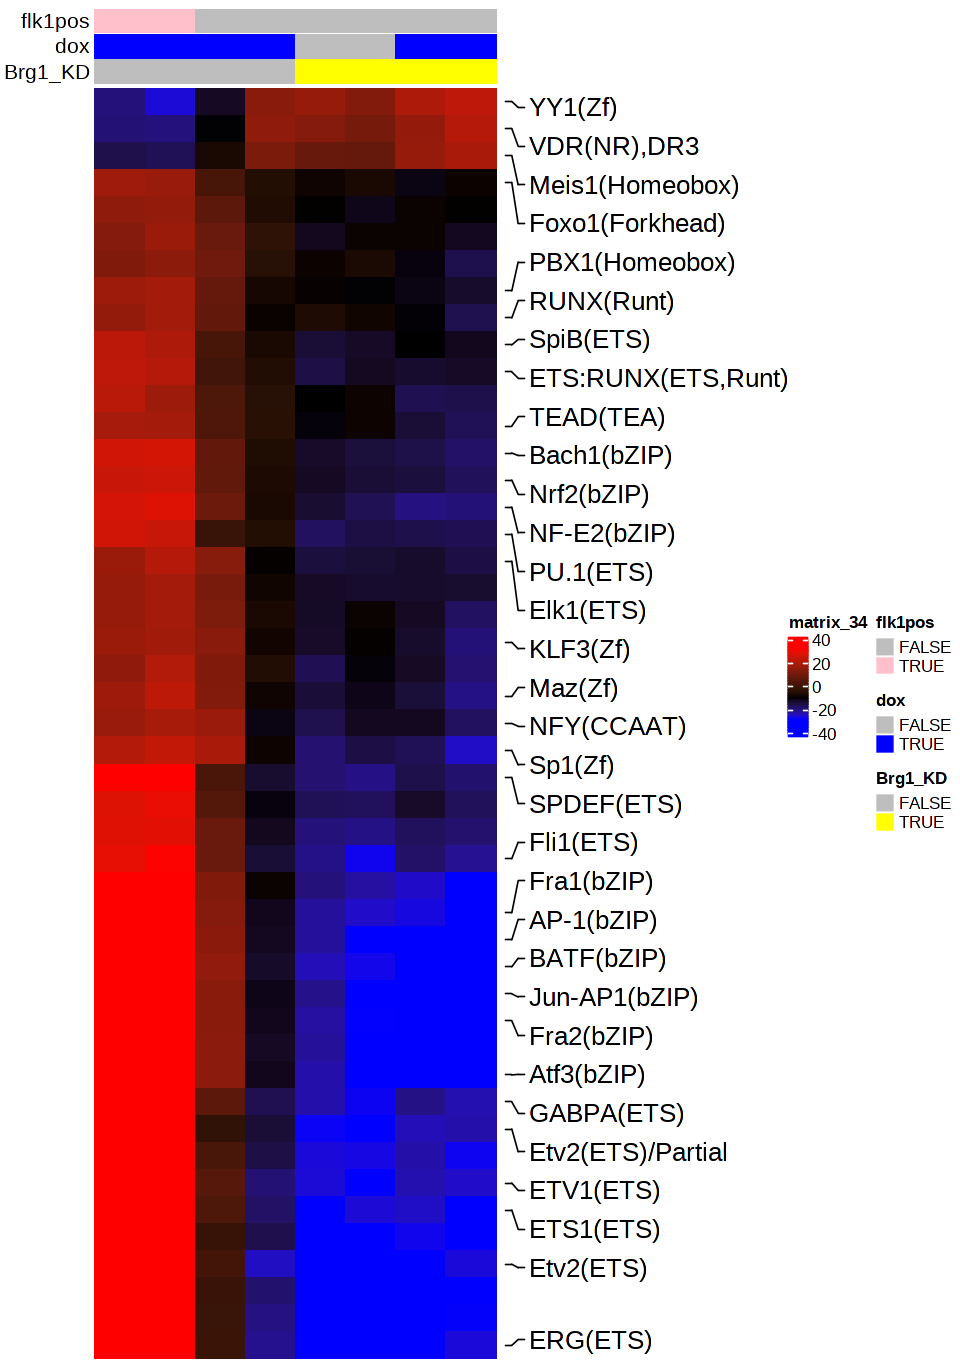

In [133]:
options(repr.plot.width = 8, repr.plot.height = nrow(Y) * 0.2 + 2)
Heatmap(
  Y,
  cluster_rows = TRUE,
  cluster_columns = TRUE,
  top_annotation = column_annotation,
  show_row_names = TRUE,
  show_column_names = FALSE,
  show_column_dend = FALSE,
  col = col_fun,
  show_row_dend = FALSE,
  row_names_gp = gpar(fontsize = 15)
) + 
  rowAnnotation(
    mark = anno_mark(
      at = which(rownames(Y) %in% highlights), 
      labels = rownames(Y)[rownames(Y) %in% highlights], 
      labels_gp = gpar(fontsize = 15), 
      padding = unit(1, "mm"), 
      which = 'row'
    ) 
  )

At D7, The Etv2 motif associated chromatin accessibility decreased in Brg1 KD cells, compared with the WT reprogramming. This suggest that Brg1 may help to retain the Etv2 bindings on the chromatin, not so much related to the initialization.

In [134]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      stats4    parallel  stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] GetoptLong_1.0.5                         
 [2] ReactomePA_1.34.0                        
 [3] clusterProfiler_3.18.0                   
 [4] org.Mm.eg.db_3.12.0                      
 [5] TxDb.Mmusculus.UCSC.mm10.knownGene_3.10.0

In [135]:
Sys.time() - start_time0

Time difference of 1.462755 mins